### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

Part 1

In [2]:
# lib section
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform

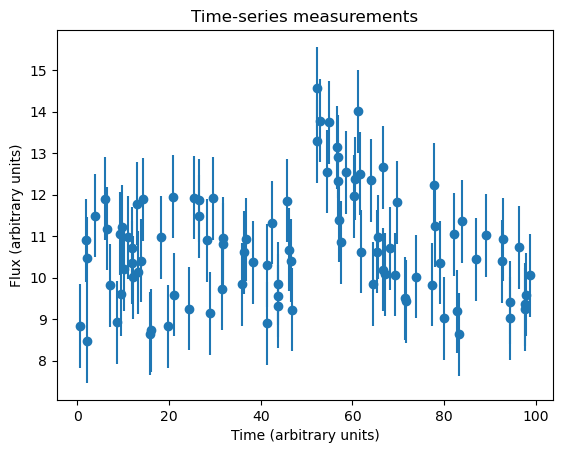

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(file_path):
    """
    Load data from a numpy file.
    """
    return np.load(file_path)

def plot_data(time, flux, flux_uncertainties):
    """
    Plot time-series data with uncertainties.
    """
    plt.errorbar(time, flux, yerr=flux_uncertainties, fmt='o')
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('Flux (arbitrary units)')
    plt.title('Time-series measurements')
    plt.show()

# Load the data
data = load_data("../../homeworks/hw_data/hw5_data_1.npy")

# Extract columns
time = data[:, 0]
flux = data[:, 1]
flux_uncertainties = data[:, 2]

# Plot the data
plot_data(time, flux, flux_uncertainties)

part 2

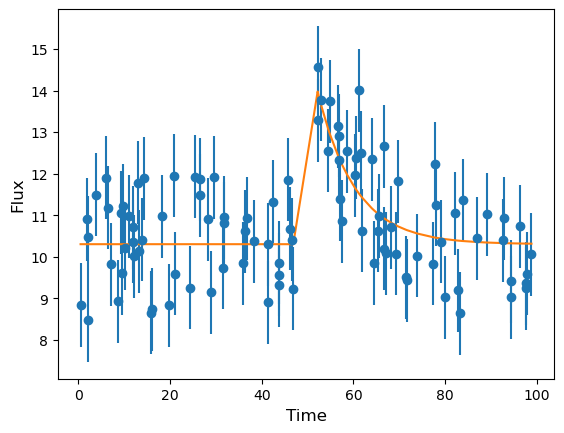

In [25]:
def burst(time, b, A, t0, alpha):
    """
    Burst model function.
    """
    y = np.full_like(time, b)
    mask = time >= t0
    y[mask] += A * np.exp(-alpha * (time[mask] - t0))
    return y

def log_likelihood(theta, time, flux, flux_uncertainties):
    """
    Log-likelihood function for the burst model.
    """
    y_model = burst(time, *theta)
    return np.sum(scipy.stats.norm.logpdf(flux, loc=y_model, scale=flux_uncertainties))

# Plotting function
def plot_data_model(time, flux, flux_uncertainties, model_params):
    """
    Plot the data and the model.
    """
    plt.errorbar(time, flux, yerr=flux_uncertainties, fmt='o')
    plt.plot(time, burst(time, *model_params))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Flux', fontsize=12)
    plt.show()

# Define model parameters
theta = [10.3, 5.4, 49.05, np.exp(-2.10)]


# Plot the data and model
plot_data_model(time, flux, flux_uncertainties, theta)

In [26]:
logL = log_likelihood(theta, time, flux, flux_uncertainties)
print(f'Log likelihood for theta = {theta}: {logL}')

Log likelihood for theta = [10.3, 5.4, 49.05, 0.1224564282529819]: -140.72851760788996


part 3

In [27]:
def log_prior(theta):
    b, A, t0, ln_alpha = theta
    if 0.0 < b < 50.0 and 0.0 < A < 50.0 and 0.0 < t0 < 100.0 and -5.0 < ln_alpha < 5.0:
        return 0.0
    return -np.inf  # log(0)

def log_likelihood(theta, time, flux, flux_uncertainties):
    y_model = burst(time, *theta[:-1], np.exp(theta[-1]))
    return np.sum(scipy.stats.norm.logpdf(flux, loc=y_model, scale=flux_uncertainties))

def log_posterior(theta, time, flux, flux_uncertainties):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, flux_uncertainties)

SRT: I think you will want the `or` rule of probability for your paper. But I see you have fixed it below.

In [34]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from scipy.stats import uniform
# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

def log_likelihood_fixed(theta):
    return log_likelihood(theta, time, flux, flux_uncertainties)

#def log_prior_fixed(theta):
#    return log_prior(theta)

# 𝑏 ∈ Uniform[0,50] , 𝐴 ∈ Uniform[0,50], 𝑡0 ∈ Uniform[0,100], and ln𝛼 ∈ Uniform[−5,5]
def log_prior_fixed(theta):
    b, A, t0, ln_alpha = theta
    prior_b = uniform(loc=0, scale=50)
    prior_A = uniform(loc=0, scale=50)
    prior_t0 = uniform(loc=0, scale=100)
    prior_ln_alpha = uniform(loc=-5, scale=10)
    return np.log(prior_b.pdf(b)) + np.log(prior_A.pdf(A)) + np.log(prior_t0.pdf(t0)) + np.log(prior_ln_alpha.pdf(ln_alpha))

sampler = ptmcmc(ndim, log_likelihood_fixed, log_prior_fixed, np.copy(cov),  outDir='./outDir', resume=False)

# sampler for N steps
N = int(1e6)
x0 = np.array([10., 10., 45., -1.])  # initial parameter values
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent in 0.004073 s Acceptance rate = 0

Finished 0.10 percent in 1.652653 s Acceptance rate = 0.876

/var/folders/m7/wmqknjsx4bj5g3v66n2dbjvr0000gr/T/ipykernel_97342/602627112.py:23: RuntimeWarning: divide by zero encountered in log
  return np.log(prior_b.pdf(b)) + np.log(prior_A.pdf(A)) + np.log(prior_t0.pdf(t0)) + np.log(prior_ln_alpha.pdf(ln_alpha))


Finished 1.00 percent in 16.405290 s Acceptance rate = 0.307333Adding DE jump with weight 50
Finished 100.00 percent in 1622.628411 s Acceptance rate = 0.369353
Run Complete


Part 4

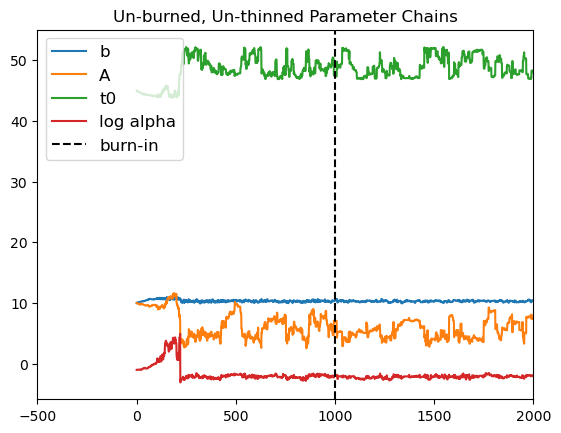

Taking every n = 6 samples based on ac length.
Burning first n = 1000 samples.


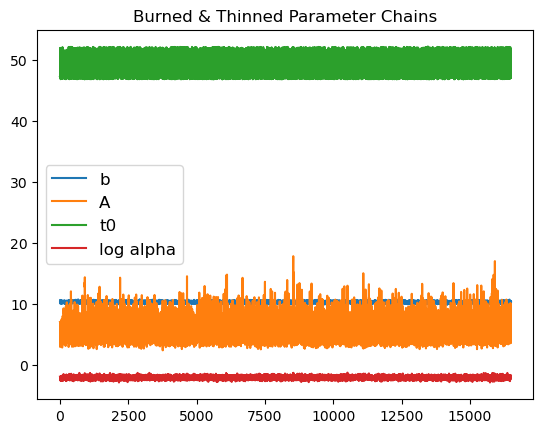

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import acor

# Load the chain from the text file
chain = np.loadtxt('./outDir/chain_1.txt')

# Plot un-burned, un-thinned parameter chains
plt.title('Un-burned, Un-thinned Parameter Chains', fontsize=12)
for i, label in enumerate(['b', 'A', 't0', 'log alpha']):
    plt.plot(chain[:, i], label=label)
plt.axvline(1000, ls='--', c='k', label='burn-in')
plt.xlim(-500, 2000)
plt.legend(loc='upper left', fontsize=12)
plt.show()

# Burn-in and thinning
burnin = 1000
thin = int(acor.acor(chain[:, 0])[0])

print(f'Taking every n = {thin} samples based on ac length.')
print(f'Burning first n = {burnin} samples.')

# Apply burn-in and thinning
chain_burned_thinned = chain[burnin::thin, :]

# Plot burned and thinned parameter chains
plt.title('Burned & Thinned Parameter Chains', fontsize=12)
for i, label in enumerate(['b', 'A', 't0', 'log alpha']):
    plt.plot(chain_burned_thinned[:, i], label=label)
plt.legend(loc='best', fontsize=12)
plt.show()

SRT: Looks great!!

part 5

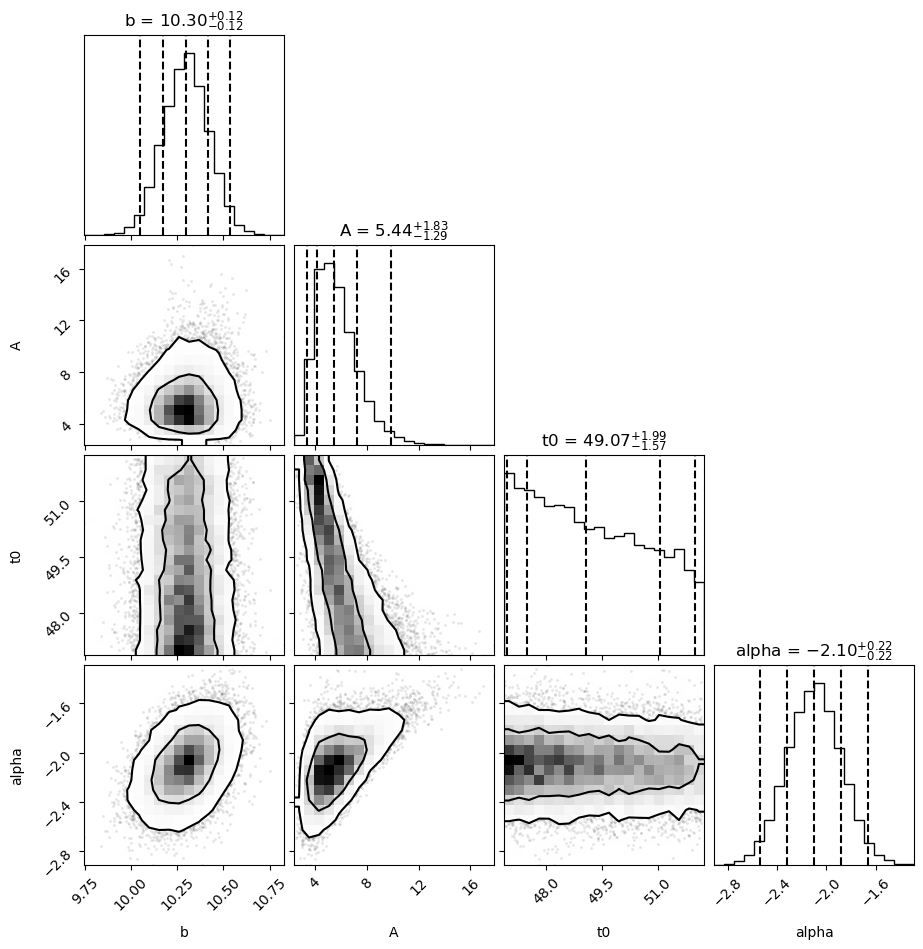

In [49]:
import corner
corner.corner(chain_burned_thinned[:,:-4], levels=[0.68,0.95], 
              quantiles=np.array([-0.477,-0.34,0,0.34,0.477])+0.5,
              title_quantiles=[0.16, 0.5, 0.84],
              labels=['b','A','t0','alpha'], titles=['b','A','t0','alpha'], show_titles=True)
plt.show()

part 6

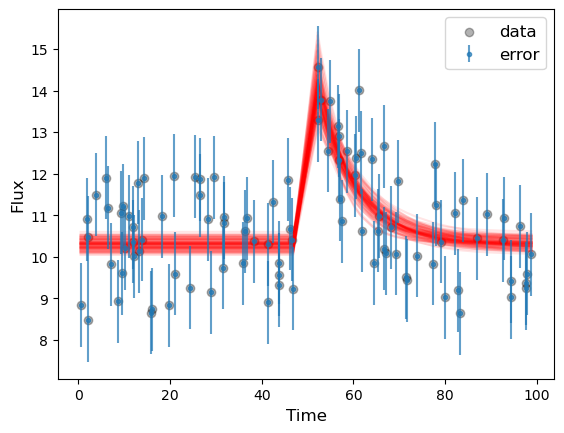

In [66]:
import random
from random import choices
# the same burst function as before
def burst(time, b, A, t0, alpha):
    """
    Burst model function.
    """
    y = np.full_like(time, b)
    mask = time >= t0
    y[mask] += A * np.exp(-alpha * (time[mask] - t0))
    return y


# Choose 100 random samples from the chain
indices = choices(range(chain_burned_thinned.shape[0]), k=100)

for index in indices:
    b_random, A_random, t0_random, alpha_random = chain_burned_thinned[index, :-4]
    burst_flux = burst(time, b_random, A_random, t0_random, np.exp(alpha_random))
    plt.plot(time, burst_flux, c='red', alpha=0.1)

plt.scatter(time, flux, c='k', label='data', alpha=0.3)
plt.errorbar(time, flux, yerr=flux_uncertainties, ls=' ', marker='.', alpha=0.7, label='error')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Flux', fontsize=12)
plt.legend(fontsize=12)
plt.show()

SRT: Awesome!

Part 7

In [134]:
import numpy as np
import dynesty
import matplotlib.pyplot as plt


def load_data(file_path):
    """
    Load data from a numpy file.
    """
    return np.load(file_path)

# Load the data
data = load_data("../../homeworks/hw_data/hw5_data_1.npy")

# Extract columns
time = data[:, 0]
flux = data[:, 1]
flux_uncertainties = data[:, 2]


def burst(t, pars):
    y = np.ones(len(time))*pars[0]
    mask = time >= pars[2]
    mask1 = np.argwhere(mask)[:,0]
    y[mask1] += pars[1] * np.exp(-pars[3] * (t[mask1] - pars[2]))

    return y

def gaussian_model(t, pars):
    return pars[0] + pars[1]*np.exp(-(t-pars[2])**2/(2*pars[3]**2))
    

#pars need to be in [b,A,t0,alpha] or [b,A,t0,sigma] order
def lnLikelihood(pars,model=burst,t=time,y=flux,sig=flux_uncertainties,addConst=True):
    if addConst:
        const = np.sum(np.log(np.sqrt(1/(2*np.pi*sig**2))))
    else:
        const=0

    return const-np.sum((y-model(t,pars))**2/(2*sig**2))

def prior_transform_burst(u):
    alpha = u.copy()
    alpha[0] = u[0]*(50-0)+0
    alpha[1] = u[1]*(50-0)+0
    alpha[2] = u[2]*(100-0)+0
    alpha[3] = np.exp(u[3]*(5+5)-5)
    return alpha

def prior_transform_gaussian(u):
    sigma = u.copy()
    sigma[0] = u[0]*(50-0)+0
    sigma[1] = u[1]*(50-0)+0
    sigma[2] = u[2]*(100-0)+0
    sigma[3] = np.exp(u[3]*(2+2)-2)
    return sigma

#test
print(prior_transform_burst([1,1,1,1]))
print(prior_transform_gaussian([1,1,1,1]))

#ndim = 4 #Both models use 4 parameters
#Use static nested sampling (more accurate evidence)

print('Starting run on burst')
burst_model_sampler = dynesty.NestedSampler(lnLikelihood, prior_transform_burst, ndim = 4, logl_args=[burst])
burst_model_sampler.run_nested()
burst_model = burst_model_sampler.results


print('Starting run on gaussian_model')
gaussian_model_sampler = dynesty.NestedSampler(lnLikelihood, prior_transform_gaussian, ndim = 4, logl_args=[gaussian_model])
gaussian_model_sampler.run_nested()
gaussian_model_2 = gaussian_model_sampler.results



[50, 50, 100, 148.4131591025766]
[50, 50, 100, 7.38905609893065]
Starting run on burst


4154it [00:14, 21.95it/s, bound: 84 | nc: 617 | ncall: 80648 | eff(%):  5.151 | loglstar:   -inf < -178.626 <    inf | logz: -185.502 +/-  0.109 | dlogz: 34.539 >  0.509]   /Users/culbreks/anaconda3/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4172it [00:16, 14.82it/s, bound: 90 | nc: 273 | ncall: 85289 | eff(%):  4.892 | loglstar:   -inf < -178.531 <    inf | logz: -185.494 +/-  0.109 | dlogz: 34.494 >  0.509]/Users/culbreks/anaconda3/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is ver

Starting run on gaussian_model


3931it [00:08, 94.76it/s, bound: 51 | nc: 172 | ncall: 55169 | eff(%):  7.125 | loglstar:   -inf < -178.958 <    inf | logz: -186.389 +/-  0.116 | dlogz: 32.135 >  0.509] /Users/culbreks/anaconda3/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3962it [00:10, 31.62it/s, bound: 60 | nc: 1215 | ncall: 62513 | eff(%):  6.338 | loglstar:   -inf < -178.808 <    inf | logz: -186.348 +/-  0.116 | dlogz: 32.032 >  0.509]/Users/culbreks/anaconda3/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very

Burst corner plot


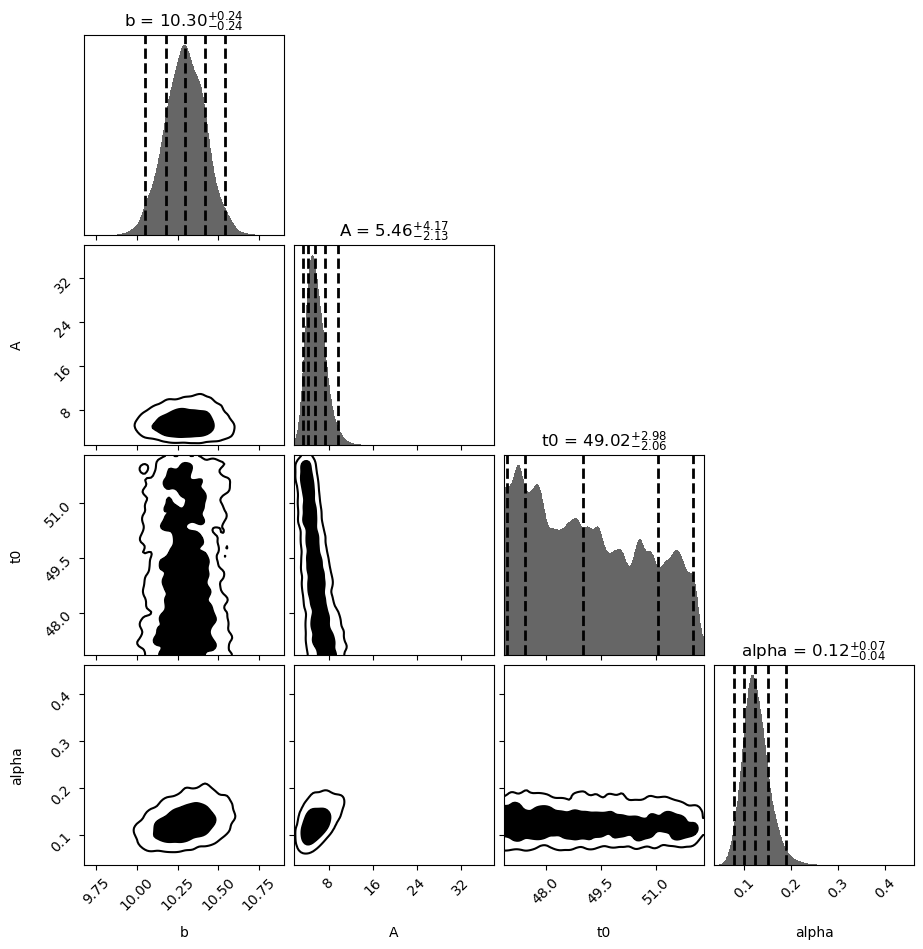

In [131]:
from dynesty import plotting as dyplot
import corner

print('Burst corner plot')
cfig, caxes = dyplot.cornerplot(burst_model,quantiles=np.array([-0.477,-0.34,0,0.34,0.477])+0.5,
                               quantiles_2d=[0.68,0.95],show_titles=True,labels=['b','A','t0','alpha'])
plt.show()

Gaussian_model corner plot


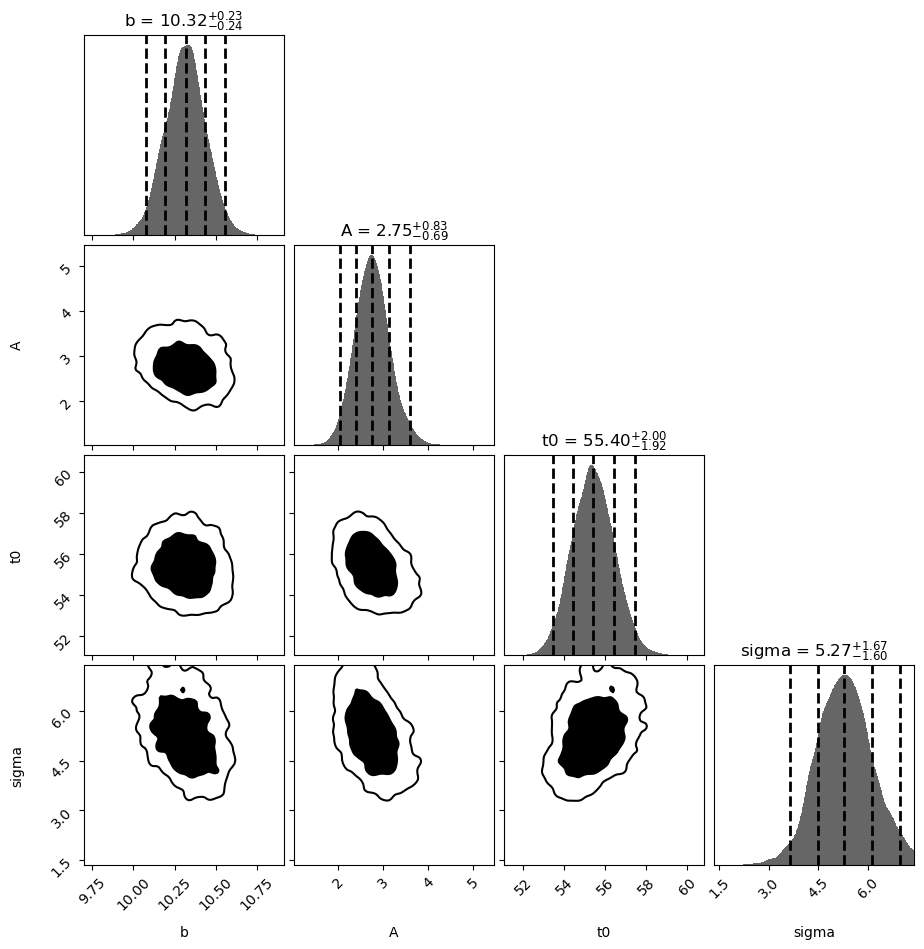

In [132]:
print('Gaussian_model corner plot')
cfig, caxes = dyplot.cornerplot(gaussian_model_2,quantiles=np.array([-0.477,-0.34,0,0.34,0.477])+0.5,
                               quantiles_2d=[0.68,0.95],show_titles=True,labels=['b','A','t0','sigma'])
plt.show()

In [133]:
burst_model_logz = burst_model['logz'][-1] #Returns evidence for each iteration, just go to end!
gaussian_model_logz = gaussian_model_2['logz'][-1]
dif_logz = burst_model_logz-gaussian_model_logz

print(f'Bayesian evidence burst: {np.exp(burst_model_logz)}')
print(f'Bayesian evidence gaussian: {np.exp(gaussian_model_logz)}')
print(f'Bayes factor: {np.exp(dif_logz)}')

Bayesian evidence burst: 3.210704296722926e-68
Bayesian evidence gaussian: 3.417118434785562e-70
Bayes factor: 93.959409309277


SRT: This was fantastic work, Kamara. Well done. I'm sorry that I have to apply a late penalty to this. 